# HoughCircles

Use `cv2.HoughCircles` function to detect droplets in double emulsions.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from corrLib import readdata

## 1 Measure the sizes in microfluidic devices
### 1.1 Test the function

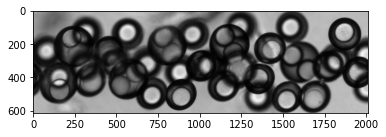

In [4]:
img = cv2.imread('sample.tif')
plt.imshow(img)

In [7]:
# convert to 8-bit
img8 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [63]:
# HoughCircle detection
circles = cv2.HoughCircles(img8, cv2.HOUGH_GRADIENT, 1.2, 20)
circles_squeeze = np.squeeze(circles)

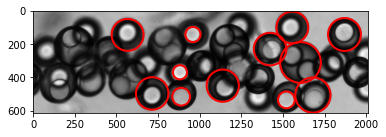

In [64]:
# Visualize the results
fig, ax = plt.subplots()
ax.imshow(img8, cmap='gray')
for c in circles_squeeze:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

<BarContainer object of 6 artists>

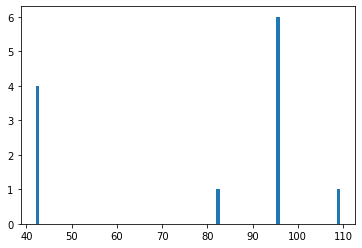

In [70]:
# show droplet size distribution
radii = circles_squeeze[:, 2]
hist, bin_edges = np.histogram(radii, bins=6)
plt.bar(bin_edges[:-1], hist)

**Comments:** 
- most detections are correctly on the droplets
- only a small fraction of droplets are detected
- the highest two peaks in the histogram give correct radii of inner and outer droplets

In [69]:
# find peak in histogram
hist

array([4, 0, 0, 1, 6, 1])

In [79]:
np.flip(np.argsort(hist))[:2]

array([4, 0])

In [84]:
# Compute the mean and std within n th peak (start from 0)
n = 4
r = radii[(radii>=bin_edges[n]) & (radii<bin_edges[n+1])]
print("number of samples: {:d}".format(len(r)))
print("mean = {0:.2f}, std = {1:.2f}".format(r.mean(), r.std()))

number of samples: 6
mean = 98.68, std = 3.23


### 1.2 Manually go over 07132021 data

In the first attempt to batch process the images, I manually go over the images of 07132021. The results will be recorded in spreadsheet **DE Size Control**.

In [86]:
# get the list of .tif files in the folder 07132021
folder = '/home/zhengyang/data/DE/07132021/'
l = readdata(folder, 'tif')

In [89]:
l

,Name,Dir
0,1000-150-250,/home/zhengyang/data/DE/07132021/1000-150-250.tif
1,1000-200-200,/home/zhengyang/data/DE/07132021/1000-200-200.tif
2,1000-250-150,/home/zhengyang/data/DE/07132021/1000-250-150.tif
3,1000-300-100-1,/home/zhengyang/data/DE/07132021/1000-300-100-...
4,1000-300-100-2,/home/zhengyang/data/DE/07132021/1000-300-100-...
5,1000-300-100-3,/home/zhengyang/data/DE/07132021/1000-300-100-...
6,1000-350-50-1,/home/zhengyang/data/DE/07132021/1000-350-50-1...
7,1000-350-50-2,/home/zhengyang/data/DE/07132021/1000-350-50-2...
8,1000-350-50-3,/home/zhengyang/data/DE/07132021/1000-350-50-3...
9,1300-400-100-1,/home/zhengyang/data/DE/07132021/1300-400-100-...


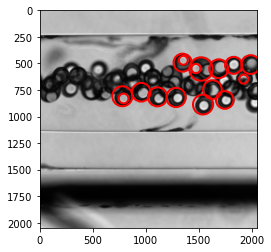

In [258]:
i = 23 # index of images (in the list above)
img = cv2.imread(l.Dir[i])
img8 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(img8, cv2.HOUGH_GRADIENT, 1.4, 20)

circles_squeeze = np.squeeze(circles)
fig, ax = plt.subplots()
ax.imshow(img8, cmap='gray')
for c in circles_squeeze:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

<BarContainer object of 4 artists>

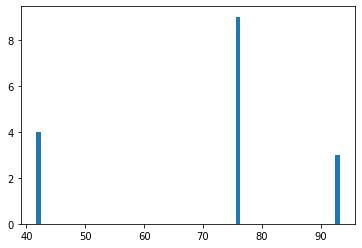

In [259]:
# show droplet size distribution
radii = circles_squeeze[:, 2]
hist, bin_edges = np.histogram(radii, bins=4)
plt.bar(bin_edges[:-1], hist)

In [253]:
np.flip(np.argsort(hist))

array([2, 3, 0, 1])

In [261]:
# Compute the mean and std within n th peak (start from 0)
n = 2
r = radii[(radii>=bin_edges[n]) & (radii<bin_edges[n+1])]
print("Flow rates: {}".format(l.Name[i]))
print("number of samples: {:d}".format(len(r)))
print("mean = {0:.2f}, std = {1:.2f}".format(r.mean(), r.std()))

Flow rates: 1500-200-100-3
number of samples: 9
mean = 86.69, std = 3.26


## 2 Inner droplet tracking

In Sec. 1 we use HoughCircle to find circles in a system of many double emulsions. Only a small fraction of droplets can be detected, but they are already sufficient for measuring the sizes.

In this section, I want to detect the position of droplets, in particular the inner droplet, in a system where only one double emulsion is present. 

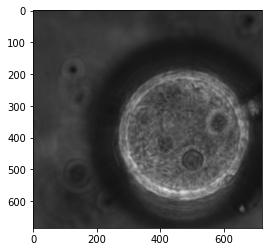

In [36]:
img = cv2.imread('sample-one-1.tif')
plt.imshow(img)
# convert to 8-bit
img8 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [127]:
# HoughCircle detection
circles = cv2.HoughCircles(img8, cv2.HOUGH_GRADIENT, 1.5, 50)

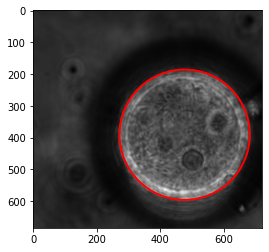

In [128]:
# Visualize the results
fig, ax = plt.subplots()
ax.imshow(img8, cmap='gray')
for c in circles[0, :, :]:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

In [125]:
# invert the image?
inv = 255 - img8
circles = cv2.HoughCircles(inv, cv2.HOUGH_GRADIENT, 1.5, 50, param2=39.4, maxRadius=40)

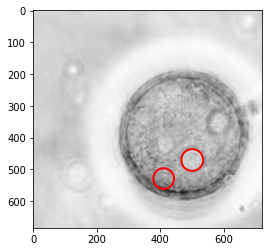

In [126]:
# Visualize the results
fig, ax = plt.subplots()
ax.imshow(inv, cmap='gray')
for c in circles[0, :, :]:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

**Comment:** 
- HoughCircles works even worse in detecting the inner droplets. 
- The bigger outer droplet detection is OK.
- Image inversion does not change the HoughCircles result at all.
- Specifying radius range and "circle perfection measure" does not help much because false detection still comes first.